In [2]:
!nvidia-smi

Thu Jul  8 18:06:59 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   58C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
import tensorflow as tf
tf.__version__

'2.5.0'

In [4]:
# Import the inception model  
from tensorflow.keras.applications.inception_v3 import InceptionV3


pre_trained_model = InceptionV3(input_shape = (150, 150, 3), 
                                include_top = False, 
                                weights = 'imagenet')

# Make all the layers in the pre-trained model non-trainable
for layer in pre_trained_model.layers:
  layer.trainable = False
  
# Print the model summary
pre_trained_model.summary()

87916544/87910968 [==============================] - 0s 0us/step
Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 74, 74, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 32)   0           batch_normalization[0][0]        
______________________

In [5]:
last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

# Expected Output:
# ('last layer output shape: ', (None, 7, 7, 768))

last layer output shape:  (None, 7, 7, 768)


In [6]:
DESIRED_ACCURACY = 0.99
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epochs, logs={}) :
        if(logs.get('acc') is not None and logs.get('acc') >= DESIRED_ACCURACY) :
            print('\nReached 99.9% accuracy so cancelling training!')
            self.model.stop_training = True

In [22]:
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import layers
from tensorflow.keras import Model
# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(128, activation='relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.3)(x)                  
# Add a final sigmoid layer for classification
x = layers.Dense  (1, activation='sigmoid')(x)           

model = Model( pre_trained_model.input, x) 

model.compile(optimizer = RMSprop(lr=0.0001), 
              loss = 'binary_crossentropy', 
              metrics = ['accuracy'])

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 74, 74, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 32)   0           batch_normalization[0][0]        
____________________________________________________________________________________________

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [23]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import zipfile

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip =True )
train_generator = train_datagen.flow_from_directory('/content/drive/MyDrive/data/train',
                                                 target_size = (150, 150),
                                                 batch_size = 32,
                                                 class_mode = 'binary')

Found 2008 images belonging to 2 classes.


In [24]:
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255)
validation_generator = test_datagen.flow_from_directory('/content/drive/MyDrive/data/test',
                                            target_size = (150,150),
                                            batch_size = 32,
                                            class_mode = 'binary')

Found 503 images belonging to 2 classes.


In [27]:
callbacks = myCallback()
history = model.fit(
            train_generator,
            validation_data = validation_generator,
            steps_per_epoch = 10,
            epochs = 5,
            validation_steps = 10,
            callbacks=[callbacks])

Epoch 1/5
10/10 [==============================] - 5s 547ms/step - loss: 0.4721 - accuracy: 0.7750 - val_loss: 0.4819 - val_accuracy: 0.7281
Epoch 2/5
10/10 [==============================] - 5s 515ms/step - loss: 0.4257 - accuracy: 0.7917 - val_loss: 0.5266 - val_accuracy: 0.7000
Epoch 3/5
10/10 [==============================] - 5s 533ms/step - loss: 0.4137 - accuracy: 0.8094 - val_loss: 0.3942 - val_accuracy: 0.8125
Epoch 4/5
10/10 [==============================] - 5s 564ms/step - loss: 0.3821 - accuracy: 0.8219 - val_loss: 0.4256 - val_accuracy: 0.7594
Epoch 5/5
10/10 [==============================] - 5s 525ms/step - loss: 0.3865 - accuracy: 0.8077 - val_loss: 0.4046 - val_accuracy: 0.8031


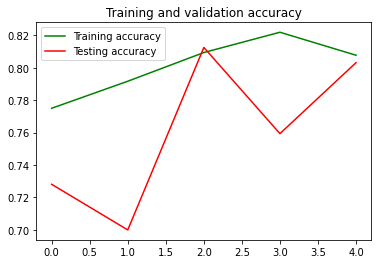

<Figure size 432x288 with 0 Axes>

In [30]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
loss = history.history['loss']
vacc = history.history['val_accuracy']
vloss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'g', label='Training accuracy')
plt.plot(epochs, vacc, 'r', label='Testing accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()

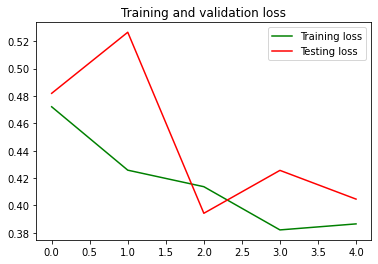

<Figure size 432x288 with 0 Axes>

In [31]:
plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, vloss, 'r', label='Testing loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()

plt.show()

In [32]:
tf.keras.models.save_model(model, 'xray_model.hdf5')

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
